# Whitelists
In this tutorial we make use of whitelists and minimum collisional radius in order to be able to control to some extent what events we are interested in tracking.

```{note}
Having to track less collisional and conjunction events has a great impact on the so-called narrow-phase of the cascade algorithm, that is the phase where cascade checks if some of the propagated objects' orbit trigger events. All other algoritmic phases are not affected by this.
```

Let us start with some imports:

In [1]:
# core imports
import cascade as csc
import pykep as pk
import numpy as np
import heyoka as hy

# plotting
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
%matplotlib inline

## The dynamics

For this tutorial we will make use the same non dimensional Keplerian dynamics used in [quickstart](<./quickstart.ipynb>).

Let us instantiate it:

In [2]:
dyn = csc.dynamics.kepler(mu = 1)


```{note}
The non dimensional units we are going to use are $L=6700 [km]$ and $\mu=1$. The orbits can thus be considered as Earth Keplerian.
```

## The initial conditions

We are considering two separated type of orbiting object. A debris cloud made of 10000 small pieces of radius 5cm and 2 active satellites operating in the same orbital environment. We will randomly create both the debris cloud and the satellite orbits.
```{tip}
We can use the very same procedure we have used in the notebooks [quickstart](<./quickstart.ipynb>) and [conjunctions](<./conjunctions.ipynb>)
```

In [3]:
N = 10000 # size of the debris cloud
M = 2     # number of active satellites
# The following numpy array will hold all the initial conditions and object radius [x,y,z,vx,vy,vz,r]
ic_state = np.zeros((N + M, 7))

# We generate randomly orbital parameters and dimensions and transform them to Cartesian state. 
# Note we make use of nondimensional units as defined in the dynamics.
for i in range(N):
    a = np.random.uniform(1.1, 1.2)
    e = np.random.uniform(0.001, 0.02)
    inc = np.random.uniform(np.pi/2-0.01, np.pi/2+0.01)
    om = np.random.uniform(0, 2 * np.pi)
    Om = np.random.uniform(np.pi/3, np.pi/3 + 0.05)
    nu = np.random.uniform(0, 2 * np.pi)
    # size corresponds roughly to 5cm
    size = np.random.uniform(6E-9, 7e-9) 
    r, v = pk.par2ic([a, e, inc, Om, om, nu], mu = 1.)
    ic_state[i][:3] = r
    ic_state[i][3:6] = v
    ic_state[i][6] = size

for i in range(i+1, i+M+1):
    a = np.random.uniform(1.1, 1.2)
    e = np.random.uniform(0, 0.02)
    inc = np.random.uniform(np.pi/2-0.01, np.pi/2 + 0.01)
    om = np.random.uniform(0, 2*np.pi)
    Om = np.random.uniform(np.pi/3, np.pi/3 + 0.05)
    nu = np.random.uniform(0, 2*np.pi)
    size = 7.46e-7
    r, v = pk.par2ic([a, e, inc, Om, om, nu], mu = 1.)
    ic_state[i][:3] = r
    ic_state[i][3:6] = v
    ic_state[i][6] = size

... and we visualize them in proportion to the Earth

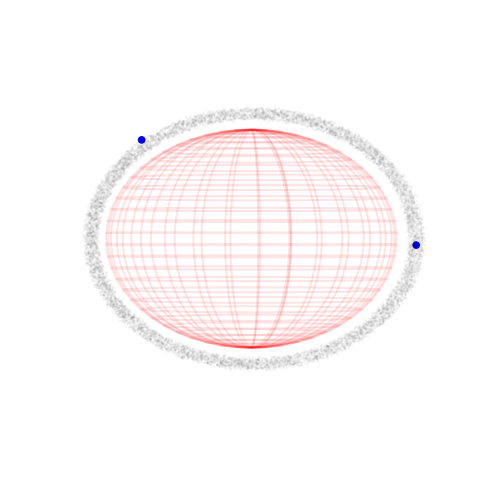

In [4]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')

r = 1
u, v = np.mgrid[0:2*np.pi:30j, 0:np.pi:30j]
x = r*np.cos(u)*np.sin(v)
y = r*np.sin(u)*np.sin(v)
z = r*np.cos(v)
ax.plot_wireframe(x, y, z, color="r", alpha=0.1)

# Plot the debris cloud
ax.scatter3D(ic_state[:,0], ic_state[:,1], ic_state[:,2], alpha=0.02, s= 1, c='k')

# Plot the active satellites
ax.scatter3D(ic_state[-2:,0], ic_state[-2:,1], ic_state[-2:,2], alpha=1, s= 20, c='b')


ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)

ax.view_init(0,-15)

plt.axis('off')
plt.tight_layout()

## Building the simulation

We now want to setup a simulation that tracks collisions and conjunctions and assess its computational complexity. Clearly we have 10002 orbiting objects and the collisional dynamics may be demanding. Before starting a simulation we then perform some profiling.

```{tip}
When setting up a new simulation and before running it, profiling the single steps as done here, as to be aware of the various timings involved is  highly reccomended!
```

We start by instantiating the simulation object.

In [5]:
sim = csc.sim(state = ic_state, dyn=dyn, ct = 2*np.pi / 10, conj_thresh = 1.5e-4, n_par_ct = 10)

We now manually perform a few steps we will discard as unreliable to then set the logger at a `trace` level to investigate performances.

In [6]:
skip = 5

In [7]:
csc.set_logger_level_info()
for i in range(skip):
    sim.step()
csc.set_logger_level_trace()
sim.step()

[2023-02-09 16:20:51.042] [cascade] [trace] ---- STEP BEGIN ---
[2023-02-09 16:20:51.042] [cascade] [trace] Number of chunks: 10
[2023-02-09 16:20:51.049] [cascade] [trace] Propagation + AABB computation time: 0.007200079s
[2023-02-09 16:20:51.050] [cascade] [trace] Morton encoding and sorting time: 0.000954682s
[2023-02-09 16:20:51.055] [cascade] [trace] BVH construction time: 0.004720873s
[2023-02-09 16:20:51.076] [cascade] [trace] Broad phase collision detection time: 0.021274176s
[2023-02-09 16:20:51.076] [cascade] [trace] Average number of AABB collisions per particle per chunk: 63.79353129374125
[2023-02-09 16:20:51.336] [cascade] [trace] Narrow phase collision detection time: 0.259795377s
[2023-02-09 16:20:51.336] [cascade] [trace] Total number of collisions detected: 0
[2023-02-09 16:20:51.336] [cascade] [trace] Total number of conjunctions detected: 21
[2023-02-09 16:20:51.336] [cascade] [trace] Runtime for append_conj_data(): 7.12e-06s
[2023-02-09 16:20:51.336] [cascade] [tra

<outcome.success: 0>

The numerical propagation, i.e. the call to all the Taylor integrators needed to construct a piecewise continuous representation of the trajectory of each object in the step (of size ``n_par_ct`` times ``ct``) as well as other parts of the cascade algorithm seem to not have much of an impact in this particular simulation. The main contribution to the total propagation time derives from the narrow phase collision. And this is where whitelists and minimal collision radius play a great role!

```{tip}
Whenever you are only interested in some specific orbiting objects, or want to exclude the detection of collisions between small objects use whitelists and set a minimal collision radius to shorten the narrow phase collision timings.
```

Since its only the active satellites that are of interest to us we will inform the cascade simulation to only care about those, ignore all the others. We also set here a ``min_coll_radius`` to exclude the detection of collisions between small debris. This is actually not needed here as the whitelists already exclude them, but we wanted to show that part of the API here too for completeness.

In [8]:
sim2 = csc.sim(state = ic_state, dyn=dyn, ct = 2*np.pi / 10, conj_thresh = 1.5e-4, n_par_ct = 10, conj_whitelist=set([10000, 10001]), coll_whitelist=set([10000, 10001]), min_coll_radius=1e-8)

[2023-02-09 16:20:51.723] [cascade] [trace] Integrators setup time: 0.338973676s
[2023-02-09 16:20:51.880] [cascade] [trace] JIT functions setup time: 0.156873615s


In [9]:
csc.set_logger_level_info()
for i in range(skip):
    sim2.step()
csc.set_logger_level_trace()
sim2.step()

[2023-02-09 16:20:52.487] [cascade] [trace] ---- STEP BEGIN ---
[2023-02-09 16:20:52.487] [cascade] [trace] Number of chunks: 10
[2023-02-09 16:20:52.493] [cascade] [trace] Propagation + AABB computation time: 0.006107527s
[2023-02-09 16:20:52.494] [cascade] [trace] Morton encoding and sorting time: 0.001275463s
[2023-02-09 16:20:52.499] [cascade] [trace] BVH construction time: 0.004842403s
[2023-02-09 16:20:52.514] [cascade] [trace] Broad phase collision detection time: 0.01530477s
[2023-02-09 16:20:52.514] [cascade] [trace] Average number of AABB collisions per particle per chunk: 0.022415516896620673
[2023-02-09 16:20:52.515] [cascade] [trace] Narrow phase collision detection time: 0.000402621s
[2023-02-09 16:20:52.515] [cascade] [trace] Total number of collisions detected: 0
[2023-02-09 16:20:52.515] [cascade] [trace] Total number of conjunctions detected: 0
[2023-02-09 16:20:52.515] [cascade] [trace] Runtime for append_conj_data(): 9.81e-07s
[2023-02-09 16:20:52.515] [cascade] [tr

<outcome.success: 0>

The narrow phase collision detection time has fallen to almost zero since cascade needs now to only care about two objects and not 10002! The overall time saving is of one order magnitude!